# Spatial Relationships

This notebook contains simple code snippets with which geometries and spatial relationships between them are analyzed.

Geometries are represented by [Shapely](https://shapely.readthedocs.io/en/stable/) objects in the `geometry` column of a `GeoDataFrame` in geopandas; these can be `Point`, `LineString`, `Polygon`, etc. Thanks to them, we can apply spatial operations.

Look at the companion guide: [`README.md`](../README.md).

Table of contents:

- 2. Spatial Relationships
    - 2.1. Shapely Geometries and Spatial Relationships
    - 2.2 Spatial Joins
      - Example 1: Add District Name to Bike Stations
      - Example 2: Make a Map of the Tree Density by District
    - 2.3 Choropleths: Mapping Attribute Data to Geometries

## 2. Spatial Relationships

In [1]:
import pandas as pd
import geopandas as gpd
import contextily
import matplotlib.pyplot as plt

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/requests/__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  RequestsDependencyWarning,


The datasets are located here:

In [2]:
DATA_PATH_PARIS = '../../data/work_geodata/Paris/'

[Shapely](https://shapely.readthedocs.io/en/stable/) is a package on its own and we can use it to create geometric objects manually, too. Shapely supports many attributes out of the box:

- `obj.area`
- `obj1.distance(obj2)`
- `obj1.contains(obj2)`
- `within()`
- `touches()`
- `intersects()`
- `centroid`
- ...

Additionally, almost all shapely object functions/attributes have an equivalent in geopandas. That way, we get GeoSeries or series of values. If these are boolean (e.g., the result of applying `contains`), we can use those series as masks in the geodataframes.


### 2.1. Shapely Geometries and Spatial Relationships


In [3]:
# Import the Point geometry
from shapely.geometry import Point

# Construct a point object for the Eiffel Tower
eiffel_tower = Point(255422.6, 6250868.9)

# Print the result
print(eiffel_tower)

POINT (255422.6 6250868.9)


In [4]:
restaurants = pd.read_csv(DATA_PATH_PARIS+"paris_restaurants.csv")
restaurants = gpd.GeoDataFrame(restaurants,
                               geometry=gpd.points_from_xy(restaurants.x,
                                                           restaurants.y))

In [5]:
restaurants.head()

,type,x,y,geometry
0,European restuarant,259641.691646,6.251867e+06,POINT (259641.692 6251867.063)
1,Traditional French restaurant,259572.339603,6.252030e+06,POINT (259572.340 6252029.683)
2,Traditional French restaurant,259657.276374,6.252143e+06,POINT (259657.276 6252143.401)
3,Indian / Middle Eastern restaurant,259684.438330,6.252203e+06,POINT (259684.438 6252203.137)
4,Traditional French restaurant,259597.943086,6.252230e+06,POINT (259597.943 6252230.044)


In [6]:
districts = gpd.read_file(DATA_PATH_PARIS+'paris_districts_utm.geojson')

In [7]:
districts.head()

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((451922.133 5411438.484, 451922.080 5..."
1,2,Halles,8984,"POLYGON ((452278.419 5412160.893, 452192.407 5..."
2,3,Palais-Royal,3195,"POLYGON ((451553.806 5412340.522, 451528.058 5..."
3,4,Place-Vendôme,3044,"POLYGON ((451004.908 5412654.095, 450960.640 5..."
4,5,Gaillon,1345,"POLYGON ((451328.752 5412991.278, 451294.721 5..."


In [8]:
# Construct a point object for the Eiffel Tower
eiffel_tower = Point(255422.6, 6250868.9)

In [9]:
# Accessing the Montparnasse geometry (Polygon) and restaurant
district_montparnasse = districts.loc[52, 'geometry']
resto = restaurants.loc[956, 'geometry']

In [10]:
# Is the Eiffel Tower located within the Montparnasse district?
print(eiffel_tower.within(district_montparnasse))

False


In [11]:
# Does the Montparnasse district contain the restaurant?
print(district_montparnasse.contains(resto))

False


In [12]:
# The distance between the Eiffel Tower and the restaurant?
print(eiffel_tower.distance(resto))

4431.459825587062


In [13]:
# Create a boolean Series
mask = districts.contains(eiffel_tower)

# Filter the districts with the boolean mask
print(districts[mask])

Empty GeoDataFrame
Columns: [id, district_name, population, geometry]
Index: []


In [14]:
# The distance from each restaurant to the Eiffel Tower
dist_eiffel = restaurants.distance(eiffel_tower)

In [15]:
# The distance to the closest restaurant
print(dist_eiffel.min())

460.69760282781715


In [16]:
# Filter the restaurants for closer than 1 km
restaurants_eiffel = restaurants[dist_eiffel<1000]

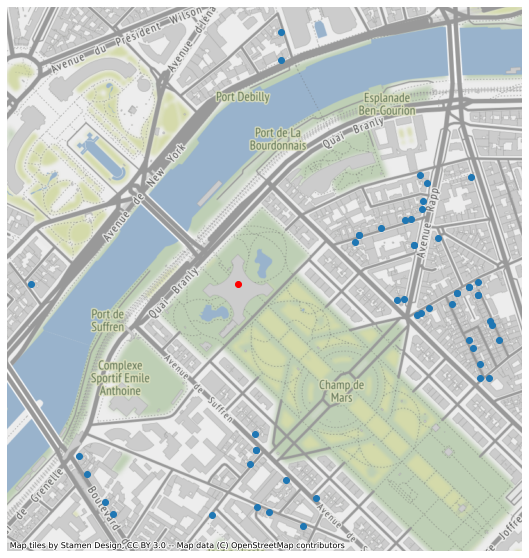

In [17]:
# Make a plot of the close-by restaurants
ax = restaurants_eiffel.plot(figsize=(10,10))
gpd.GeoSeries([eiffel_tower]).plot(ax=ax, color='red')
contextily.add_basemap(ax)
ax.set_axis_off()

### 2.2 Spatial Joins

Spatial joins make possible many geospatial analyses; for instance, if we have two geometry maps of a city, one with neighborhoods/districts and the other with public school points and their regions, we can ask: do they match? which districts have several schools or which schools contain several districts?

Spatial joins are done with 

      gpd.sjoin(left_df=gdf1, right_df=gdf2, op=...)

Data from the right dataframe is added to the left one. The operation, `op`, can be:

- `'intersects'`: all points/data which intersect both dataframes are returned.
- `'contains'`: data contained in the first/left dataframe.
- `'within'`: data contained in the second/right dataframe.
- If we don't pass an operation, both datasets are shown.

Since in one geometry column can be district polygons and the other schools points, a join can filter points (schools) within polygons (districts). Thus, we're performing geometry operations.

Note that:

- All the specified columns of the left dataframe are returned.
- All the specified columns of the right dataframe are returned, **except the `geometry` column**. The `geometry` of the right is used for the join, but not added to the joined dataframe. Only the `geometry` of the left appears in the joined dataframe.

#### Example 1: Add District Name to Bike Stations

In [18]:
districts = gpd.read_file(DATA_PATH_PARIS+'paris_districts_utm.geojson')

In [19]:
stations = gpd.read_file(DATA_PATH_PARIS+'paris_sharing_bike_stations_utm.geojson')

In [20]:
districts.head()

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((451922.133 5411438.484, 451922.080 5..."
1,2,Halles,8984,"POLYGON ((452278.419 5412160.893, 452192.407 5..."
2,3,Palais-Royal,3195,"POLYGON ((451553.806 5412340.522, 451528.058 5..."
3,4,Place-Vendôme,3044,"POLYGON ((451004.908 5412654.095, 450960.640 5..."
4,5,Gaillon,1345,"POLYGON ((451328.752 5412991.278, 451294.721 5..."


In [21]:
stations.head()

,name,bike_stands,available_bikes,geometry
0,14002 - RASPAIL QUINET,44,4,POINT (450804.449 5409797.268)
1,20503 - COURS DE VINCENNES PYRÉNÉES,21,3,POINT (456414.352 5410698.461)
2,20011 - PYRÉNÉES-DAGORNO,21,0,POINT (456366.909 5411563.320)
3,31008 - VINCENNES (MONTREUIL),56,0,POINT (458730.707 5411789.995)
4,43006 - MINIMES (VINCENNES),28,27,POINT (458234.930 5409991.067)


In [46]:
# Add district name where each station is located
joined = gpd.sjoin(left_df=stations, right_df=districts, op='within')
joined.head()

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,name,bike_stands,available_bikes,geometry,index_right,id,district_name,population
0,14002 - RASPAIL QUINET,44,4,POINT (450804.449 5409797.268),52,53,Montparnasse,18570
143,14112 - FAUBOURG SAINT JACQUES CASSINI,16,0,POINT (451419.447 5409421.529),52,53,Montparnasse,18570
293,14033 - DAGUERRE GASSENDI,38,1,POINT (450708.228 5409406.941),52,53,Montparnasse,18570
346,14006 - SAINT JACQUES TOMBE ISSOIRE,22,0,POINT (451340.026 5409124.575),52,53,Montparnasse,18570
429,14111 - DENFERT-ROCHEREAU CASSINI,24,8,POINT (451274.511 5409609.731),52,53,Montparnasse,18570


#### Example 2: Make a Map of the Tree Density by District

In [23]:
trees = gpd.read_file(DATA_PATH_PARIS+'paris_trees_small.gpkg')

In [25]:
trees.head()

,species,location_type,geometry
0,Marronnier,Alignement,POINT (455834.122 5410780.606)
1,Marronnier,Alignement,POINT (446546.284 5412574.697)
2,Marronnier,Alignement,POINT (449768.283 5409876.557)
3,Marronnier,Alignement,POINT (451779.708 5409292.071)
4,Sophora,Alignement,POINT (447041.361 5409756.712)


In [30]:
# 1. Add to each tree the district it belongs to
joined = gpd.sjoin(left_df=trees,
                   #right_df=districts[['district_name', 'geometry']],
                   right_df=districts,
                   op="within")

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [61]:
joined.head()

,name,bike_stands,available_bikes,geometry,index_right,id,district_name,population
0,14002 - RASPAIL QUINET,44,4,POINT (450804.449 5409797.268),52,53,Montparnasse,18570
143,14112 - FAUBOURG SAINT JACQUES CASSINI,16,0,POINT (451419.447 5409421.529),52,53,Montparnasse,18570
293,14033 - DAGUERRE GASSENDI,38,1,POINT (450708.228 5409406.941),52,53,Montparnasse,18570
346,14006 - SAINT JACQUES TOMBE ISSOIRE,22,0,POINT (451340.026 5409124.575),52,53,Montparnasse,18570
429,14111 - DENFERT-ROCHEREAU CASSINI,24,8,POINT (451274.511 5409609.731),52,53,Montparnasse,18570


In [41]:
# 2. Calculate the number of trees in each district
trees_by_district = joined.groupby('district_name').size()

In [42]:
# 3. Convert the series to a DataFrame and specify column name
trees_by_district = trees_by_district.to_frame(name='n_trees')

In [43]:
trees_by_district.head()

,n_trees
district_name,
Amérique,183
Archives,8
Arsenal,60
Arts-et-Metiers,20
Auteuil,392


In [44]:
# 4. Merge the 'districts' and 'trees_by_district' dataframes
districts_trees = pd.merge(left=districts,
                           right=trees_by_district,
                           on='district_name')

In [45]:
districts_trees.head()

,id,district_name,population,geometry,n_trees
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((451922.133 5411438.484, 451922.080 5...",40
1,2,Halles,8984,"POLYGON ((452278.419 5412160.893, 452192.407 5...",40
2,3,Palais-Royal,3195,"POLYGON ((451553.806 5412340.522, 451528.058 5...",4
3,4,Place-Vendôme,3044,"POLYGON ((451004.908 5412654.095, 450960.640 5...",7
4,5,Gaillon,1345,"POLYGON ((451328.752 5412991.278, 451294.721 5...",7


In [48]:
# 5. Add a column with the tree density
districts_trees['n_trees_per_area'] = (districts_trees.n_trees / districts_trees.geometry.area)*10**6

In [49]:
districts_trees.head()

,id,district_name,population,geometry,n_trees,n_trees_per_area
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((451922.133 5411438.484, 451922.080 5...",40,46.054411
1,2,Halles,8984,"POLYGON ((452278.419 5412160.893, 452192.407 5...",40,97.031529
2,3,Palais-Royal,3195,"POLYGON ((451553.806 5412340.522, 451528.058 5...",4,14.622589
3,4,Place-Vendôme,3044,"POLYGON ((451004.908 5412654.095, 450960.640 5...",7,25.992249
4,5,Gaillon,1345,"POLYGON ((451328.752 5412991.278, 451294.721 5...",7,37.251926


<AxesSubplot:>

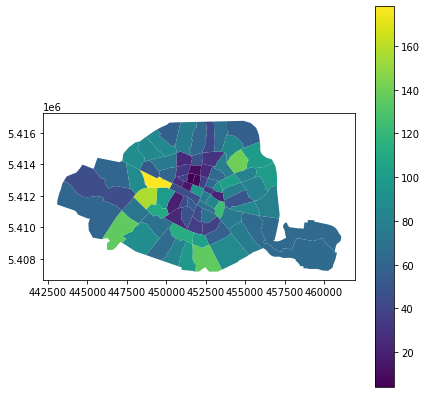

In [59]:
# 6. Make of map of the districts colored by 'n_trees_per_area'
# Color maps can be controled with cmap: https://matplotlib.org/stable/tutorials/colors/colormaps.html
districts_trees.plot(column='n_trees_per_area',
                     legend=True,
                     figsize=(7,7))

### 2.3 Choropleths: Mapping Attribute Data to Geometries

From the [Wikipedia](https://en.wikipedia.org/wiki/Choropleth_map):

> A **choropleth** map is a type of statistical thematic map that uses pseudocolor, i.e., color corresponding with an aggregate summary of a geographic characteristic within spatial enumeration units, such as population density or per-capita income.

Recall that a geodataframe has a `geometry` column and the rest of the columns are called *attribute* columns. When we plot a geodataframe, the `geometry` elements are plotted, and if these are polygons, we need to specify which attribute to plot in the `column` argument. The result is a **choropleth**, as the one shown in the previous example.

An important aspect when plotting are color maps, `cmap`, because they help understand the polygons in one way or another: [Choosing Colormaps in Matplotlib](https://matplotlib.org/stable/tutorials/colors/colormaps.html). Color maps can be:

- Qualitative: miscellaneous colors, no ordering, for categorical data.
- Sequential (graduated): numerical information, with ordering/degree.
- Diverging (graduated): they start in the middle.
- Cyclic: start and end with the same color

Numerical columns default to continuous sequential color maps, however, it's better to define ranges with the arguments `scheme` and `k`:

- Choose `scheme=quantiles` or `scheme=equal_interval` depending on how we want to define the bins.
- Choose the number of bins `k` between 3 and 12.
- Always plot the distribution of the numerical value to see how to best define the bins.

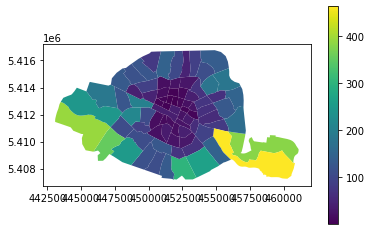

In [68]:
# Make a choropleth of the number of trees 
districts_trees.plot(column='n_trees', legend=True)
plt.show()

<AxesSubplot:>

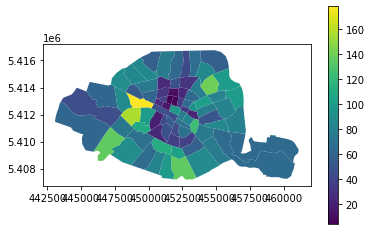

In [69]:
# Make a choropleth of the number of trees 
districts_trees.plot(column='n_trees_per_area', legend=True)

<AxesSubplot:>

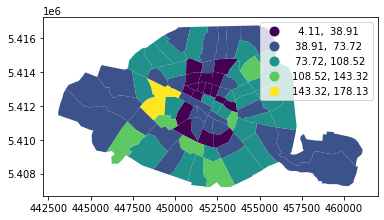

In [84]:
# Make a choropleth of the number of trees / area
districts_trees.plot(column='n_trees_per_area', scheme='equal_interval', legend=True)

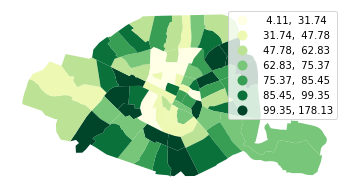

In [71]:
# Generate the choropleth and store the axis
ax = districts_trees.plot(column='n_trees_per_area',
                          scheme='quantiles',
                          k=7,
                          cmap='YlGn',
                          legend=True)

# Remove frames, ticks and tick labels from the axis
ax.set_axis_off()

<AxesSubplot:>

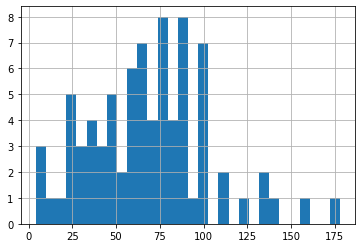

In [77]:
districts_trees['n_trees_per_area'].hist(bins=30)

In [78]:
import seaborn as sns

<AxesSubplot:xlabel='n_trees_per_area', ylabel='Count'>

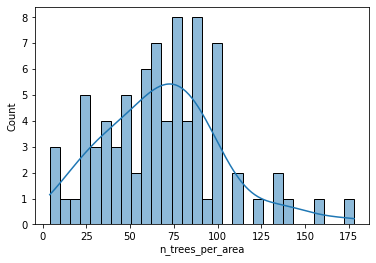

In [81]:
sns.histplot(districts_trees['n_trees_per_area'], bins=30, kde=True)

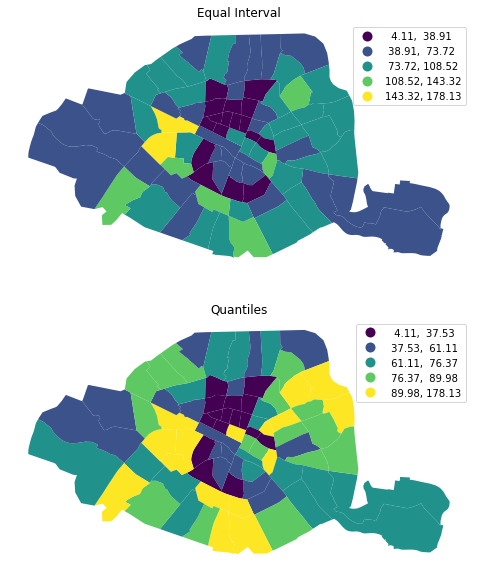

In [83]:
# Set up figure and subplots
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

# Plot equal interval map
districts_trees.plot(column='n_trees_per_area', scheme='equal_interval', k=5, legend=True, ax=axes[0])
axes[0].set_title('Equal Interval')
axes[0].set_axis_off()

# Plot quantiles map
districts_trees.plot(column='n_trees_per_area', scheme='quantiles', k=5, legend=True, ax=axes[1])
axes[1].set_title('Quantiles')
axes[1].set_axis_off()

# Display maps
plt.show()